# Pole detection from point cloud

## Process followed:
* Import data
* Visualize data
* Process point cloud data
    * Downsample
    * Remove outliers
* Planar filtering
* Clustering points into poles (With automatic number of poles computation)
* Fitting a spline to the pole
* Visualize results

Import libraries

In [2]:
import numpy as np
import open3d as o3d
import csv
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import collections
%matplotlib inline
import sys

## Define global variables

In [3]:
lat = []
lon = []
alt = []
intensity = []

## Some useful functions

Converting Lat, Lon, Alt to XYZ

In [4]:
def LLA_to_XYZ(Lat,Lon,Alt,intensity):
    ''' Takes Latitude, Longitude and Altitdue and converts this data into
    x,y and z cartesion co-ordinates. Returns intensity as is.'''
    r_earth = (6378.137*1000)
    LatCos = np.cos(Lat*np.pi/180)
    LatSin = np.sin(Lat*np.pi/180)
    LonCos = np.cos(Lon*np.pi/180)
    LonSin = np.sin(Lon*np.pi/180)
    f = 1.0 / 298.257224
    C = 1.0/ np.sqrt(LatCos**2 + ((1-f)**2)*((LatSin)**2))
    S = ((1.0 - f)**2)*(C)
    x = (r_earth*C)*LatCos*LonCos
    y = (r_earth*C)*LatCos*LonSin
    z = Alt
    return x,y,z,intensity

Reading in the data

In [5]:
def readfile(filename):
    ''' This function reads the file -"filename"- and appends 
    the data to the lat,lon,alt and intensity arrays '''
    global lat,lon,alt,intensity
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter =' ')
        for row in reader:
            lat.append(float(row[0]))
            lon.append(float(row[1]))
            alt.append(float(row[2]))
            intensity.append(float(row[3]))

## Visualizing the initial data

Reading in the data

In [6]:
readfile("final_project_data/final_project_point_cloud.fuse")
points_xyzi = np.ones((len(lat),4))

Converting from Lat, Long, Alt to XYZ 

In [7]:
for i in range(0,len(lat)):
    points_xyzi[i] = LLA_to_XYZ(lat[i],lon[i],alt[i],intensity[i])

Check shape of the data

In [8]:
print(points_xyzi.shape)

(430736, 4)


Check some examples of what we have

In [9]:
print(lat[31])
print(lon[31])
print(alt[31])
print(intensity[31])
print(points_xyzi[31])

45.90370042
11.02826286
226.2948
4.0
[4.36390869e+06 8.50492097e+05 2.26294800e+02 4.00000000e+00]


Function to create a point cloud object

In [10]:
def write_point_cloud_object(array,name):
    ''' Takes array of point cloud (x,y,z) data and writes it to a 
    point cloud object file viewable in meshLab'''
    pc_object = open(name,"w")
    for j in array:
        pc_object.write("v "+str(j[0])+" "+str(j[1])+" "+str(j[2])+"\n")
    pc_object.close

In [11]:
write_point_cloud_object(points_xyzi,"All_data.obj")

### Show the raw point cloud

In [12]:
#Using open3d - creating open3d object
p = o3d.geometry.PointCloud()

#Assigning points to the open3D object
p.points = o3d.utility.Vector3dVector(points_xyzi[ : , 0:3])

#Assigning colors to each point
intens = np.zeros((np.size(points_xyzi[ : , 3]),3))
p.colors = o3d.utility.Vector3dVector(intens)

#Write point cloud
o3d.io.write_point_cloud("./Alldata.ply", p)

#Show visualization
o3d.visualization.draw_geometries([p])

## Downsampling the point cloud

In [13]:
#Downsampling by voxel
down_voxel = o3d.geometry.voxel_down_sample(p, voxel_size=0.8)
o3d.io.write_point_cloud("./Downsampled_voxel.ply", down_voxel)
# o3d.visualization.draw_geometries([down_voxel])


#Downsampling uniformly
down_uniform = o3d.geometry.uniform_down_sample(p, every_k_points=5)
o3d.io.write_point_cloud("./Downsampled_uniform.ply", down_uniform)
# o3d.visualization.draw_geometries([down_uniform])

#Downsampling statistical outlier removal
down_stats, ind = o3d.geometry.statistical_outlier_removal(down_voxel,nb_neighbors=50,std_ratio=5.0)
# inliers = o3d.geometry.select_down_sample(down_stats, ind)
o3d.io.write_point_cloud("./Downsampled_Removed_Stat_Outliers.ply", down_stats)
#o3d.visualization.draw_geometries([down_stats])

True

Check number of points in each of the downsampled batches

In [14]:
print("Number of points in original point cloud:")
print(np.size(p.points))
print("Number of points in voxel downsampled point cloud:")
print(np.size(down_voxel.points))
print("Number of points after statistical outlier removal:")
print(np.size(down_stats.points))

Number of points in original point cloud:
1292208
Number of points in voxel downsampled point cloud:
39780
Number of points after statistical outlier removal:
39630


## Filtering data based on a planar grid system

This method will snap points to a grid. 
For each set of points that lie on a vertex of two dimensions that grid the variation in the third dimensionof the grid can be used to filter the data points.
This is a relatively fast computation to perform but does rely on inexact co-ordinates owing to the grid snap procedure.

Here is a function to achieve this general principle:

In [15]:
def planar_filter(xyzi, grid_size, lower_bound, filter_axis):
    # Calculating the scaling factor for the grid size
    scale = 1 / grid_size
    if scale > 0:
        scale = int(scale)
    
    # Create array of points snapped to the grid
    x_snap = np.round(xyzi[:, 0] * scale)
    y_snap = np.round(xyzi[:, 1] * scale)
    z_snap = np.round(xyzi[:, 2] * scale)

    # Dictionaries to store information about each vertex
    grids_perp_x = collections.defaultdict(list)
    grids_perp_y = collections.defaultdict(list)
    grids_perp_z = collections.defaultdict(list)
    
    # Store information about points snapped to each 2D vertex
    for i in range(len(xyzi)):
        x_close = x_snap[i]
        y_close = y_snap[i]
        z_close = z_snap[i]
        x = xyzi[i, 0]
        y = xyzi[i, 1]
        z = xyzi[i, 2]
        grids_perp_z[(x_close, y_close)].append((i, z))
        grids_perp_y[(x_close, z_close)].append((i, y))
        grids_perp_x[(y_close, z_close)].append((i, x))
    
    poi = []
    # Filter to snap points to grid in xy plane and use z as a metric
    if filter_axis == 'z':
        for xy, i_and_z in grids_perp_z.items():
            list_idx, list_z = zip(*i_and_z)
            if max(list_z) - min(list_z) >= lower_bound:
                poi.extend(list_idx)
    # Filter to snap points to grid in xz plane and use y as a metric
    if filter_axis == 'y':
        for xz, i_and_y in grids_perp_y.items():
            list_idx, list_y = zip(*i_and_y)
            if max(list_y) - min(list_y) <= lower_bound:
                poi.extend(list_idx)
    # Filter to snap points to grid in yz plane and use x as a metric
    if filter_axis == 'x':
        for yz, i_and_x in grids_perp_x.items():
            list_idx, list_x = zip(*i_and_x)
            if max(list_x) - min(list_x) <= lower_bound:
                poi.extend(list_idx)

    return poi


### Using the planar filter
Here we use the planar filter on all of the raw point cloud data. 
We first snap points to the xy plane and then use variation in z as our filtering criterion.
We filter out any vertex set of points that do not have a large enough variation in z.

In [16]:
poi = planar_filter(points_xyzi, grid_size=0.5, lower_bound=6, filter_axis = 'z')
xyza_planar = points_xyzi[poi, :]

## Clustering points belonging to each pole together

### Determining the number of poles
It is quite nice to have the code automatically determine the number of poles in the point cloud. 
This can be done using the elbow method. https://en.wikipedia.org/wiki/Elbow_method_(clustering)

We assume there will be less than 20 poles in a point cloud

In [17]:
limit = 10

In [18]:
X_scaled = preprocessing.scale(xyza_planar[:,0:2])
X_norm = preprocessing.normalize(xyza_planar[:, 0:2], norm='l2')

scores = []
for i in range(limit):
    scores.append((KMeans(n_clusters=i+1).fit(X_scaled)).inertia_)

In [19]:
delta_scores = np.zeros((limit-1,1))
for i in range(limit-1):
    delta_scores[i] = scores[i]/scores[i+1]

In [20]:
print(scores)
print(delta_scores)

[5212.0, 2535.0194523410046, 1410.6890645300573, 787.2602516035803, 429.90852628298444, 202.1512547902377, 90.23435631525213, 10.383769130925721, 8.31137016405089, 6.83103496991505]
[[2.056     ]
 [1.79700794]
 [1.79189672]
 [1.83122735]
 [2.12666761]
 [2.24029143]
 [8.68994246]
 [1.24934504]
 [1.21670731]]


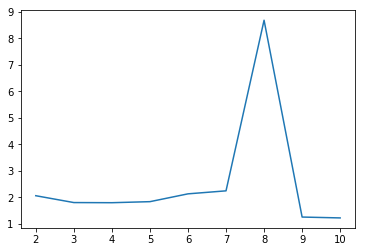

In [21]:
x = range(2,limit+1)
plt.plot(x,delta_scores)
number_of_clusters = np.argmax(delta_scores)+2
# we add 2 to the number of clusters since we lose 1 by starting the list at index 0 and we lose another
# one as we are looking at the transition from having x to x+1 clusters

## Clustering based on correct number of clusters

Using Kmeans from sklearn library for clustering.

Not the most robust clustering algorithm for spatially complex shapes.

Relatively fast computation.

Clustering is performed only on x and y co-ordinates.

In [22]:
y_pred = KMeans(n_clusters=number_of_clusters).fit_predict(xyza_planar[:,0:2])

In [23]:
#Using open3d - creating open3d object
p = o3d.geometry.PointCloud()

p.points = o3d.utility.Vector3dVector(xyza_planar[ : , 0:3])
# help(o3d.geometry.PointCloud().colors)
colours = np.array([[0,0,0],[255,0,255],[0,255,255],[255,0,0],[0,255,0],[0,0,255],[255,128,0],[102,0,51],[0,128,255],[0,0,0],[255,255,0],[255,0,255],[0,255,255],[255,0,0],[0,255,0],[0,0,255],[128,255,0],[255,128,0],[0,128,255],[0,0,0]])
colours = colours/255.0
intens = np.zeros((np.size(xyza_planar[ : , 3]),3))


for i in range(len(y_pred)):
    intens[i] = colours[y_pred[i]]


p.colors = o3d.utility.Vector3dVector(intens)
#p.colors = o3d.utility.Vector3dVector(points_xyzi[ : , 3])
o3d.io.write_point_cloud("./Results.ply", p)
o3d.visualization.draw_geometries([p])

Line-fitting to x-z plane plot of the point cloud pole data

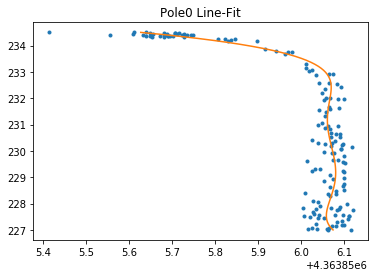

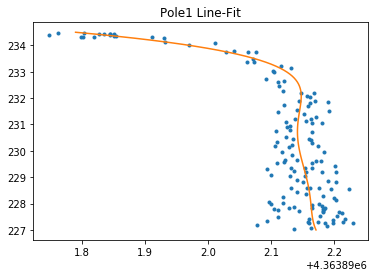

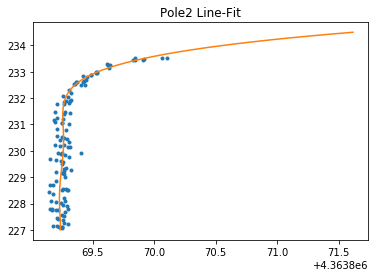

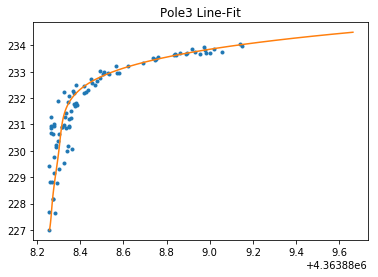

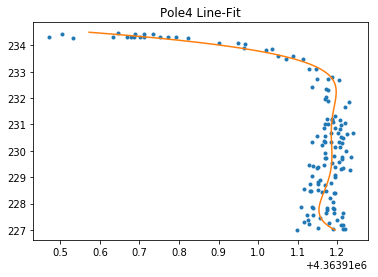

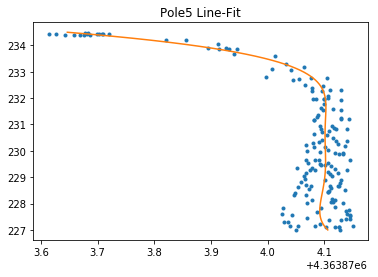

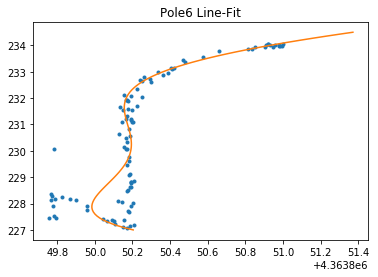

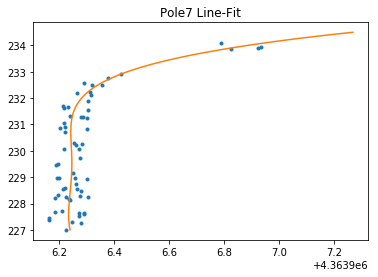

In [24]:
#splitting xyza planar into different poles based on labels in y_pred
pole0 = np.zeros((1,4))
pole1 = np.zeros((1,4))
pole2 = np.zeros((1,4))
pole3 = np.zeros((1,4))
pole4 = np.zeros((1,4))
pole5 = np.zeros((1,4))
pole6 = np.zeros((1,4))
pole7 = np.zeros((1,4))

for i in range(len(y_pred)):
    if(y_pred[i]==0):
        #only add point if it's actually part of the pole and not the ground
        #that's clustered with the pole; simple threshold based on plotting
        if(xyza_planar[i,2]>227.0):
            pole0 = np.append(pole0,xyza_planar[i,:].reshape((1,4)),axis=0)
    elif(y_pred[i]==1):
        if(xyza_planar[i,2]>227.0):
            pole1 = np.append(pole1,xyza_planar[i,:].reshape((1,4)),axis=0)
    elif(y_pred[i]==2):
        if(xyza_planar[i,2]>227.0):
            pole2 = np.append(pole2,xyza_planar[i,:].reshape((1,4)),axis=0)
    elif(y_pred[i]==3):
        if(xyza_planar[i,2]>227.0 and xyza_planar[i,0]>4363850.1):
            pole3 = np.append(pole3,xyza_planar[i,:].reshape((1,4)),axis=0)
    elif(y_pred[i]==4):
        if(xyza_planar[i,2]>227.0):
            pole4 = np.append(pole4,xyza_planar[i,:].reshape((1,4)),axis=0)
    elif(y_pred[i]==5):
        if(xyza_planar[i,2]>227.0):
            pole5 = np.append(pole5,xyza_planar[i,:].reshape((1,4)),axis=0)
    elif(y_pred[i]==6):
        if(xyza_planar[i,2]>227.0):
            pole6 = np.append(pole6,xyza_planar[i,:].reshape((1,4)),axis=0)
    elif(y_pred[i]==7):
        if(xyza_planar[i,2]>227.0 and xyza_planar[i,0]>4363906.0):
            pole7 = np.append(pole7,xyza_planar[i,:].reshape((1,4)),axis=0)

pole0 = pole0[1:,:]
pole1 = pole1[1:,:]
pole2 = pole2[1:,:]
pole3 = pole3[1:,:]
pole4 = pole4[1:,:]
pole5 = pole5[1:,:]
pole6 = pole6[1:,:]
pole7 = pole7[1:,:]
            
np.set_printoptions(threshold=sys.maxsize)
#print(np.sort(pole3[:,0]))

p0 = np.poly1d(np.polyfit(pole0[:,2],pole0[:,0],5))
p1 = np.poly1d(np.polyfit(pole1[:,2],pole1[:,0],5))
p2 = np.poly1d(np.polyfit(pole2[:,2],pole2[:,0],5))
p3 = np.poly1d(np.polyfit(pole3[:,2],pole3[:,0],5))
p4 = np.poly1d(np.polyfit(pole4[:,2],pole4[:,0],5))
p5 = np.poly1d(np.polyfit(pole5[:,2],pole5[:,0],5))
p6 = np.poly1d(np.polyfit(pole6[:,2],pole6[:,0],5))
p7 = np.poly1d(np.polyfit(pole7[:,2],pole7[:,0],5))
xp = np.linspace(227,234.5,100)

plt.plot(pole0[:,0],pole0[:,2],'.', p0(xp),xp, '-')
plt.title('Pole0 Line-Fit')
plt.show()
plt.plot(pole1[:,0],pole1[:,2],'.', p1(xp),xp, '-')
plt.title('Pole1 Line-Fit')
plt.show()
plt.plot(pole2[:,0],pole2[:,2],'.', p2(xp),xp, '-')
plt.title('Pole2 Line-Fit')
plt.show()
plt.plot(pole3[:,0],pole3[:,2],'.', p3(xp),xp, '-')
plt.title('Pole3 Line-Fit')
plt.show()
plt.plot(pole4[:,0],pole4[:,2],'.', p4(xp),xp, '-')
plt.title('Pole4 Line-Fit')
plt.show()
plt.plot(pole5[:,0],pole5[:,2],'.', p5(xp),xp, '-')
plt.title('Pole5 Line-Fit')
plt.show()
plt.plot(pole6[:,0],pole6[:,2],'.', p6(xp),xp, '-')
plt.title('Pole6 Line-Fit')
plt.show()
plt.plot(pole7[:,0],pole7[:,2],'.', p7(xp),xp, '-')
plt.title('Pole7 Line-Fit')
plt.show()

In [25]:
xyz_load = np.asarray(down_voxel.points)
print(xyz_load[0])

[4.36385641e+06 8.50503315e+05 2.25276640e+02]


In [26]:
#Get the normals
normals = p
#Play with radius and nn numbers
o3d.geometry.estimate_normals(normals,search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.2,max_nn=10)) 
o3d.visualization.draw_geometries([normals]) #press n to see the normals

In [27]:
print(points_xyzi[0])
print(points_xyzi[1])  
print(points_xyzi[2])  
print(points_xyzi[50000])  

[4.36389211e+06 8.50500778e+05 2.32464800e+02 1.00000000e+01]
[4.36391065e+06 8.50489133e+05 2.34470600e+02 5.00000000e+00]
[4.36391069e+06 8.50489257e+05 2.34445900e+02 7.00000000e+00]
[4.36390992e+06 8.50475555e+05 2.26499300e+02 4.00000000e+00]


In [28]:
print("Range x")
print(np.max(points_xyzi[:,0]))
print(np.min(points_xyzi[:,0]))
print("Range y")
print(np.max(points_xyzi[:,1]))
print(np.min(points_xyzi[:,1]))
print("Range z")
print(np.max(points_xyzi[:,2]))
print(np.min(points_xyzi[:,2]))

Range x
4363936.394832086
4363824.2325811405
Range y
850591.3313508638
850396.0078237783
Range z
234.5053
221.8044
